Available keys: dict_keys(['__header__', '__version__', '__globals__', 'signal'])
Signal shape: (1000000, 3)


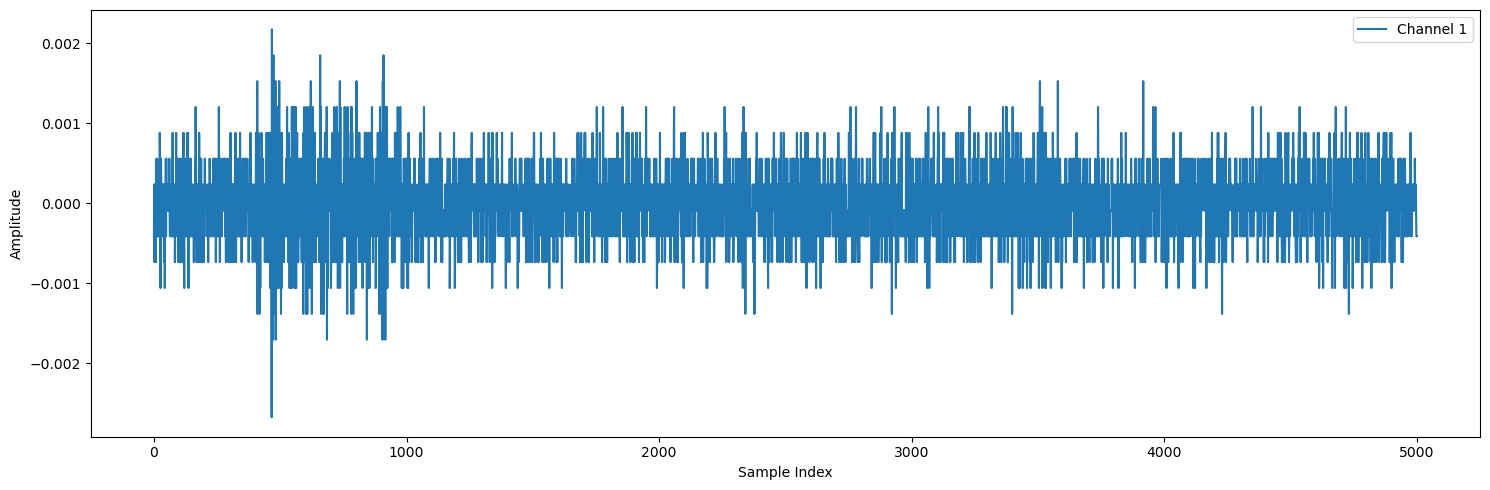

In [7]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to one sample .mat file
file_path = r"F:\test data conference\7bar_0.3mm\Leak\1.mat"

# Load .mat file
data = sio.loadmat(file_path)

# Inspect keys
print("Available keys:", data.keys())

# Extract signal assuming it's stored in key 'signal'
signal = data['signal']  # (1000000, 3)
print("Signal shape:", signal.shape)

# Plot first 5000 samples from each channel
plt.figure(figsize=(15, 5))
for i in range(1):
    plt.plot(signal[:5000, i], label=f'Channel {i+1}')
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import skew, kurtosis

# Parameters
segment_size = 100_000  # 0.1 second per segment
num_segments = signal.shape[0] // segment_size
num_channels = signal.shape[1]

# Function to extract features per segment
def extract_features(segment):
    features = []
    for ch in range(num_channels):
        ch_data = segment[:, ch]
        features.extend([
            np.mean(ch_data),
            np.std(ch_data),
            skew(ch_data),
            kurtosis(ch_data),
            np.sum(ch_data ** 2)  # Energy
        ])
    return features

# Segment the signal and extract features
all_features = []
for i in range(num_segments):
    start = i * segment_size
    end = start + segment_size
    segment = signal[start:end, :]
    features = extract_features(segment)
    all_features.append(features)

all_features = np.array(all_features)
print("Segmented feature matrix shape:", all_features.shape)  # Expected: (10, 15)


Segmented feature matrix shape: (10, 15)


In [9]:
import torch
from torch_geometric.data import Data

# Convert features to tensor
x = torch.tensor(all_features, dtype=torch.float)  # Shape: [10, 15]

# Create edges between consecutive segments (bidirectional)
edge_index = []
for i in range(num_segments - 1):
    edge_index.append([i, i+1])  # forward
    edge_index.append([i+1, i])  # backward
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Shape: [2, 18]

# Create graph object (temporary dummy label for now)
graph = Data(x=x, edge_index=edge_index, y=torch.tensor([1]))  # assume leak for demo

print(graph)


Data(x=[10, 15], edge_index=[2, 18], y=[1])


In [10]:
import glob
from tqdm import tqdm

# Paths and labels
data_paths = {
    r"F:\test data conference\Normal": 0,
    r"F:\test data conference\7bar_0.3mm\Leak": 1,
    r"F:\test data conference\7bar_0.5mm\Leak": 2,
    r"F:\test data conference\7bar_1mm\Leak": 3
}

# Final graph dataset
graph_list = []

# Process all files
for folder, label in data_paths.items():
    mat_files = glob.glob(os.path.join(folder, "*.mat"))
    for file_path in tqdm(mat_files, desc=f"Processing {folder}"):
        try:
            data = sio.loadmat(file_path)
            signal = data['signal']  # (1000000, 3)

            # Segmenting and feature extraction
            all_features = []
            for i in range(10):
                start = i * 100_000
                end = start + 100_000
                segment = signal[start:end, :]
                features = extract_features(segment)
                all_features.append(features)

            x = torch.tensor(all_features, dtype=torch.float)

            # Temporal edges
            edge_index = []
            for i in range(9):
                edge_index.append([i, i+1])
                edge_index.append([i+1, i])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            # Graph object
            graph = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
            graph_list.append(graph)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")


Processing F:\test data conference\Normal: 100%|██████████| 103/103 [00:14<00:00,  7.19it/s]
Processing F:\test data conference\7bar_0.3mm\Leak: 100%|██████████| 101/101 [00:12<00:00,  8.42it/s]
Processing F:\test data conference\7bar_0.5mm\Leak: 100%|██████████| 101/101 [00:12<00:00,  7.85it/s]
Processing F:\test data conference\7bar_1mm\Leak:  15%|█▍        | 15/101 [00:01<00:09,  9.14it/s]

Error processing F:\test data conference\7bar_1mm\Leak\2.mat: Error -3 while decompressing data: invalid code lengths set


Processing F:\test data conference\7bar_1mm\Leak: 100%|██████████| 101/101 [00:12<00:00,  7.84it/s]


In [11]:
# Stage 1: Binary classification (0 = Normal, 1 = Leak)
binary_graph_list = []
for g in graph_list:
    binary_label = 0 if g.y.item() == 0 else 1
    new_g = g.clone()
    new_g.y = torch.tensor([binary_label], dtype=torch.long)
    binary_graph_list.append(new_g)

# Stage 2: Multi-class classification (only for leaks: 0.3mm, 0.5mm, 1.0mm)
leak_graph_list = []
for g in graph_list:
    if g.y.item() != 0:
        new_g = g.clone()
        new_g.y = torch.tensor([g.y.item() - 1], dtype=torch.long)  # 1→0, 2→1, 3→2
        leak_graph_list.append(new_g)

# Summary
print(f"Stage 1 - Binary Graphs: {len(binary_graph_list)}")
print(f"Stage 2 - Leak Only Graphs: {len(leak_graph_list)}")


Stage 1 - Binary Graphs: 405
Stage 2 - Leak Only Graphs: 302


In [12]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Split binary dataset (Stage 1)
train_bin, test_bin = train_test_split(
    binary_graph_list, 
    test_size=0.2, 
    stratify=[g.y.item() for g in binary_graph_list], 
    random_state=42
)

# Create DataLoaders
train_loader_bin = DataLoader(train_bin, batch_size=16, shuffle=True)
test_loader_bin = DataLoader(test_bin, batch_size=16, shuffle=False)

print(f"Stage 1 - Train: {len(train_bin)} | Test: {len(test_bin)}")


Stage 1 - Train: 324 | Test: 81


In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNBinaryLeakDetector(nn.Module):
    def __init__(self, in_channels=15, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = nn.Linear(hidden_channels, 32)
        self.fc2 = nn.Linear(32, 2)  # Binary: Normal or Leak

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level pooling
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # raw logits


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bin = GCNBinaryLeakDetector().to(device)

optimizer = torch.optim.Adam(model_bin.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Test loop
def test(model, loader):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    acc = correct / len(loader.dataset)
    return acc, all_preds, all_labels

# Run training
for epoch in range(1, 31):
    loss = train(model_bin, train_loader_bin)
    acc, _, _ = test(model_bin, test_loader_bin)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


Epoch 01 | Loss: 0.2489 | Test Accuracy: 0.9877
Epoch 02 | Loss: 0.0988 | Test Accuracy: 0.9877
Epoch 03 | Loss: 0.0358 | Test Accuracy: 0.9877
Epoch 04 | Loss: 0.0148 | Test Accuracy: 1.0000
Epoch 05 | Loss: 0.0075 | Test Accuracy: 1.0000
Epoch 06 | Loss: 0.0044 | Test Accuracy: 1.0000
Epoch 07 | Loss: 0.0028 | Test Accuracy: 1.0000
Epoch 08 | Loss: 0.0019 | Test Accuracy: 1.0000
Epoch 09 | Loss: 0.0013 | Test Accuracy: 1.0000
Epoch 10 | Loss: 0.0010 | Test Accuracy: 1.0000
Epoch 11 | Loss: 0.0007 | Test Accuracy: 1.0000
Epoch 12 | Loss: 0.0005 | Test Accuracy: 1.0000
Epoch 13 | Loss: 0.0004 | Test Accuracy: 1.0000
Epoch 14 | Loss: 0.0003 | Test Accuracy: 1.0000
Epoch 15 | Loss: 0.0003 | Test Accuracy: 1.0000
Epoch 16 | Loss: 0.0002 | Test Accuracy: 1.0000
Epoch 17 | Loss: 0.0002 | Test Accuracy: 1.0000
Epoch 18 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 19 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 20 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 21 | Loss: 0.0001 | Test Accuracy:

In [15]:
# Stage 2 split (leak only)
train_size, test_size = 0.8, 0.2

train_leak, test_leak = train_test_split(
    leak_graph_list,
    test_size=test_size,
    stratify=[g.y.item() for g in leak_graph_list],
    random_state=42
)

# DataLoaders
train_loader_leak = DataLoader(train_leak, batch_size=16, shuffle=True)
test_loader_leak = DataLoader(test_leak, batch_size=16, shuffle=False)

print(f"Stage 2 - Train: {len(train_leak)} | Test: {len(test_leak)}")


Stage 2 - Train: 241 | Test: 61


In [16]:
class GCNLeakSizeClassifier(nn.Module):
    def __init__(self, in_channels=15, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = nn.Linear(hidden_channels, 32)
        self.fc2 = nn.Linear(32, 3)  # 3 leak sizes: 0.3mm, 0.5mm, 1.0mm

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [45]:
model_leak = GCNLeakSizeClassifier().to(device)
optimizer = torch.optim.Adam(model_leak.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop (reuse same train/test functions)
for epoch in range(1, 41):
    loss = train(model_leak, train_loader_leak)
    acc, _, _ = test(model_leak, test_loader_leak)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


Epoch 01 | Loss: 1.4059 | Test Accuracy: 0.6721
Epoch 02 | Loss: 0.6624 | Test Accuracy: 1.0000
Epoch 03 | Loss: 0.4378 | Test Accuracy: 0.6721
Epoch 04 | Loss: 0.2926 | Test Accuracy: 0.9508
Epoch 05 | Loss: 0.3024 | Test Accuracy: 0.8361
Epoch 06 | Loss: 0.3685 | Test Accuracy: 0.9344
Epoch 07 | Loss: 0.2730 | Test Accuracy: 0.6721
Epoch 08 | Loss: 0.2668 | Test Accuracy: 0.9016
Epoch 09 | Loss: 0.2906 | Test Accuracy: 0.9672
Epoch 10 | Loss: 0.1312 | Test Accuracy: 0.9672
Epoch 11 | Loss: 0.1252 | Test Accuracy: 1.0000
Epoch 12 | Loss: 0.1757 | Test Accuracy: 0.8525
Epoch 13 | Loss: 0.1602 | Test Accuracy: 1.0000
Epoch 14 | Loss: 0.1032 | Test Accuracy: 1.0000
Epoch 15 | Loss: 0.1036 | Test Accuracy: 1.0000
Epoch 16 | Loss: 0.0827 | Test Accuracy: 1.0000
Epoch 17 | Loss: 0.0550 | Test Accuracy: 1.0000
Epoch 18 | Loss: 0.0901 | Test Accuracy: 0.9836
Epoch 19 | Loss: 0.0863 | Test Accuracy: 1.0000
Epoch 20 | Loss: 0.0704 | Test Accuracy: 1.0000
Epoch 21 | Loss: 0.0362 | Test Accuracy:

In [46]:
def predict_pipeline(graph, model_stage1, model_stage2):
    graph = graph.to(device)
    batch = torch.zeros(graph.num_nodes, dtype=torch.long).to(device)

    # Stage 1: Leak detection
    out1 = model_stage1(graph.x, graph.edge_index, batch)
    leak_pred = out1.argmax(dim=1).item()

    if leak_pred == 0:
        return "Normal (No Leak)"
    else:
        out2 = model_stage2(graph.x, graph.edge_index, batch)
        size_pred = out2.argmax(dim=1).item()
        size_map = {0: "0.3mm", 1: "0.5mm", 2: "1.0mm"}
        return f"Leak Detected → Size: {size_map[size_pred]}"


In [47]:
# Try predictions on first few graphs
for i in range(10):
    result = predict_pipeline(graph_list[i], model_bin, model_leak)
    true_label = graph_list[i].y.item()
    print(f"[{i}] True Label: {true_label} → Prediction: {result}")


[0] True Label: 0 → Prediction: Normal (No Leak)
[1] True Label: 0 → Prediction: Normal (No Leak)
[2] True Label: 0 → Prediction: Normal (No Leak)
[3] True Label: 0 → Prediction: Normal (No Leak)
[4] True Label: 0 → Prediction: Normal (No Leak)
[5] True Label: 0 → Prediction: Normal (No Leak)
[6] True Label: 0 → Prediction: Normal (No Leak)
[7] True Label: 0 → Prediction: Normal (No Leak)
[8] True Label: 0 → Prediction: Normal (No Leak)
[9] True Label: 0 → Prediction: Normal (No Leak)


In [48]:
# Get all predictions and true labels for Stage 1
_, y_pred_bin, y_true_bin = test(model_bin, test_loader_bin)


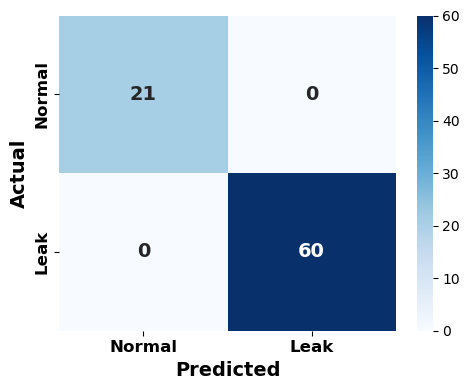


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        21
        Leak       1.00      1.00      1.00        60

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



In [49]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels_stage1 = ['Normal', 'Leak']
cm_bin = confusion_matrix(y_true_bin, y_pred_bin)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_stage1, yticklabels=labels_stage1, annot_kws={"size": 14, "fontweight": "bold"})

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold', rotation=90)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true_bin, y_pred_bin, target_names=labels_stage1))


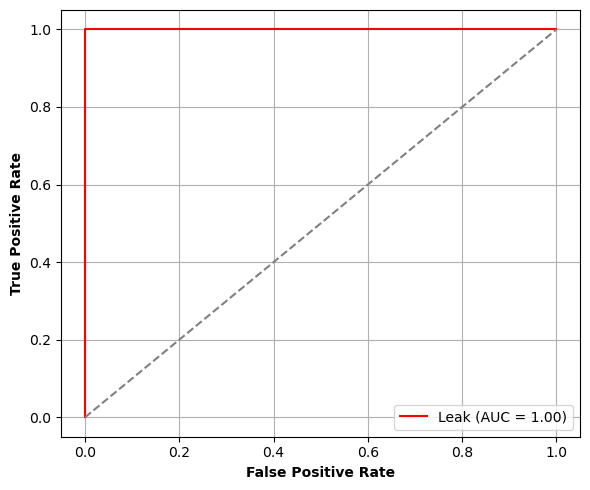

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize labels
y_true_bin_onehot = label_binarize(y_true_bin, classes=[0, 1])

# Get raw scores (logits) for ROC
model_bin.eval()
y_score_bin = []
with torch.no_grad():
    for data in test_loader_bin:
        data = data.to(device)
        out = model_bin(data.x, data.edge_index, data.batch)
        y_score_bin.extend(out.cpu().numpy())

y_score_bin = np.array(y_score_bin)

# Compute ROC
fpr, tpr, _ = roc_curve(y_true_bin_onehot.ravel(), y_score_bin[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Leak (AUC = {roc_auc:.2f})", color="red")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')

plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


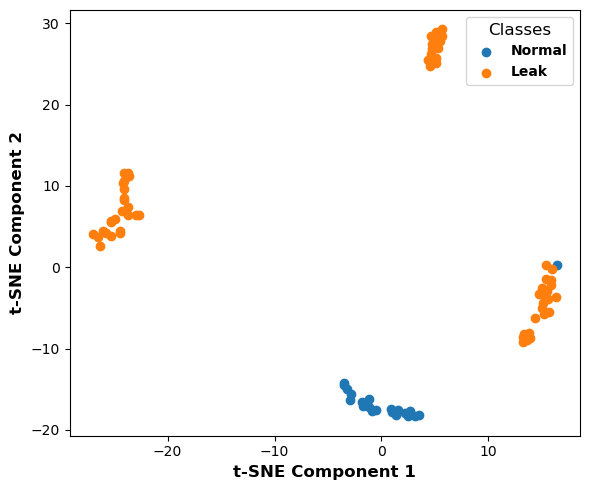

In [51]:
from sklearn.manifold import TSNE

# Collect graph-level embeddings
model_bin.eval()
embeddings_bin = []
labels_bin = []

with torch.no_grad():
    for data in test_loader_bin:
        data = data.to(device)
        x = model_bin.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = model_bin.conv2(x, data.edge_index)
        x = F.relu(x)
        pooled = global_mean_pool(x, data.batch)
        embeddings_bin.append(pooled.cpu().numpy())
        labels_bin.extend(data.y.cpu().numpy())

embeddings_bin = np.vstack(embeddings_bin)

# Apply t-SNE
tsne_bin = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_result = tsne_bin.fit_transform(embeddings_bin)

colors = ['blue', 'red']

# Plot
plt.figure(figsize=(6, 5))
for label in [0, 1]:
    idxs = np.where(np.array(labels_bin) == label)
    label_text = labels_stage1[label]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=label_text, alpha=1)


plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='12')
plt.xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


In [52]:
_, y_pred_leak, y_true_leak = test(model_leak, test_loader_leak)


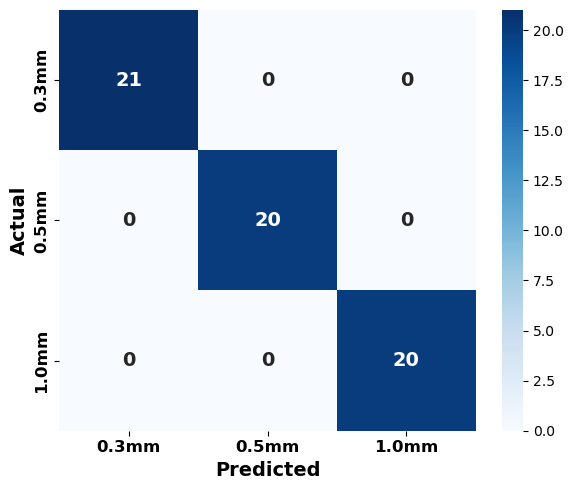


Classification Report:
              precision    recall  f1-score   support

       0.3mm       1.00      1.00      1.00        21
       0.5mm       1.00      1.00      1.00        20
       1.0mm       1.00      1.00      1.00        20

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



In [53]:
labels_stage2 = ['0.3mm', '0.5mm', '1.0mm']
cm_leak = confusion_matrix(y_true_leak, y_pred_leak)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_leak, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_stage2, yticklabels=labels_stage2, annot_kws={"size": 14, "fontweight": "bold"})

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold', rotation=90)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true_leak, y_pred_leak, target_names=labels_stage2))


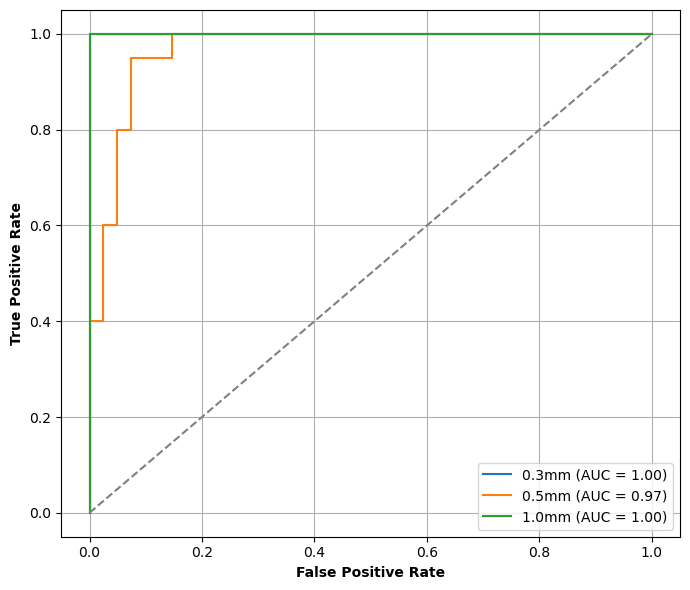

In [55]:
# Binarize true labels
y_true_leak_bin = label_binarize(y_true_leak, classes=[0, 1, 2])

# Get logits
model_leak.eval()
y_score_leak = []
with torch.no_grad():
    for data in test_loader_leak:
        data = data.to(device)
        out = model_leak(data.x, data.edge_index, data.batch)
        y_score_leak.extend(out.cpu().numpy())

y_score_leak = np.array(y_score_leak)

# Plot ROC curve for each class
plt.figure(figsize=(7, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_leak_bin[:, i], y_score_leak[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels_stage2[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


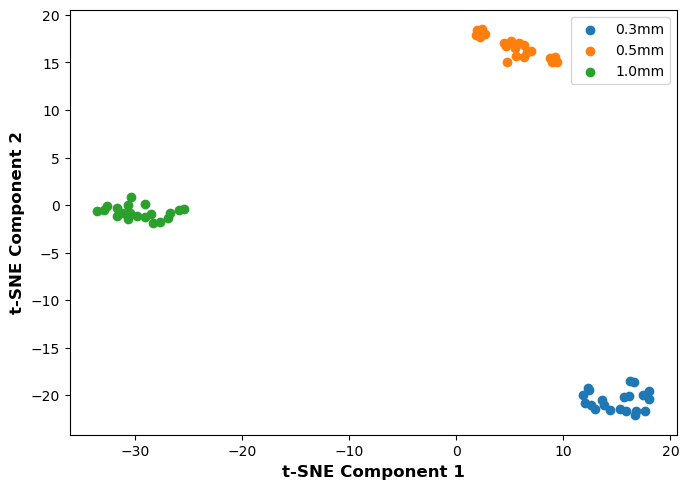

In [57]:
# Collect graph-level embeddings
model_leak.eval()
embeddings_leak = []
labels_leak = []

with torch.no_grad():
    for data in test_loader_leak:
        data = data.to(device)
        x = model_leak.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = model_leak.conv2(x, data.edge_index)
        x = F.relu(x)
        pooled = global_mean_pool(x, data.batch)
        embeddings_leak.append(pooled.cpu().numpy())
        labels_leak.extend(data.y.cpu().numpy())

embeddings_leak = np.vstack(embeddings_leak)

# t-SNE
tsne_leak = TSNE(n_components=2, perplexity=10, random_state=42)
tsne_result_leak = tsne_leak.fit_transform(embeddings_leak)

# Plot
plt.figure(figsize=(7, 5))
for i, label in enumerate(labels_stage2):
    idxs = np.where(np.array(labels_leak) == i)
    plt.scatter(tsne_result_leak[idxs, 0], tsne_result_leak[idxs, 1], label=label, alpha=1)

plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='12')
plt.xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
losses_stage1 = []
accuracies_stage1 = []

for epoch in range(1, 41):
    loss = train(model_bin, train_loader_bin)
    acc, _, _ = test(model_bin, test_loader_bin)
    losses_stage1.append(loss)
    accuracies_stage1.append(acc)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


Epoch 01 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 02 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 03 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 04 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 05 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 06 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 07 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 08 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 09 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 10 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 11 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 12 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 13 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 14 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 15 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 16 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 17 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 18 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 19 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 20 | Loss: 0.0001 | Test Accuracy: 1.0000
Epoch 21 | Loss: 0.0001 | Test Accuracy:

In [59]:
losses_stage2 = []
accuracies_stage2 = []

for epoch in range(1, 41):
    loss = train(model_leak, train_loader_leak)
    acc, _, _ = test(model_leak, test_loader_leak)
    losses_stage2.append(loss)
    accuracies_stage2.append(acc)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


Epoch 01 | Loss: 0.0188 | Test Accuracy: 1.0000
Epoch 02 | Loss: 0.0091 | Test Accuracy: 1.0000
Epoch 03 | Loss: 0.0129 | Test Accuracy: 1.0000
Epoch 04 | Loss: 0.0032 | Test Accuracy: 1.0000
Epoch 05 | Loss: 0.0178 | Test Accuracy: 1.0000
Epoch 06 | Loss: 0.0042 | Test Accuracy: 1.0000
Epoch 07 | Loss: 0.0083 | Test Accuracy: 1.0000
Epoch 08 | Loss: 0.0091 | Test Accuracy: 0.9836
Epoch 09 | Loss: 0.0303 | Test Accuracy: 1.0000
Epoch 10 | Loss: 0.0101 | Test Accuracy: 1.0000
Epoch 11 | Loss: 0.0073 | Test Accuracy: 1.0000
Epoch 12 | Loss: 0.0113 | Test Accuracy: 1.0000
Epoch 13 | Loss: 0.0225 | Test Accuracy: 1.0000
Epoch 14 | Loss: 0.0053 | Test Accuracy: 1.0000
Epoch 15 | Loss: 0.0162 | Test Accuracy: 1.0000
Epoch 16 | Loss: 0.0218 | Test Accuracy: 1.0000
Epoch 17 | Loss: 0.0022 | Test Accuracy: 1.0000
Epoch 18 | Loss: 0.1650 | Test Accuracy: 0.6885
Epoch 19 | Loss: 0.2340 | Test Accuracy: 1.0000
Epoch 20 | Loss: 0.1066 | Test Accuracy: 1.0000
Epoch 21 | Loss: 0.0628 | Test Accuracy:

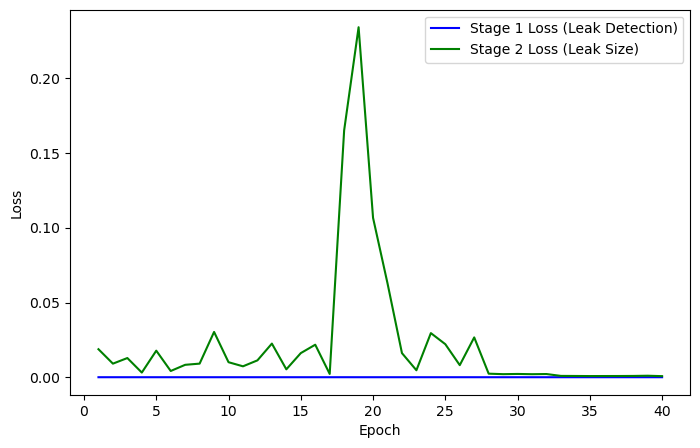

In [73]:
import matplotlib.pyplot as plt

epochs = range(1, 41)

plt.figure(figsize=(8, 5))

# Loss plots

plt.plot(epochs, losses_stage1, label='Stage 1 Loss (Leak Detection)', color='blue')
plt.plot(epochs, losses_stage2, label='Stage 2 Loss (Leak Size)', color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()





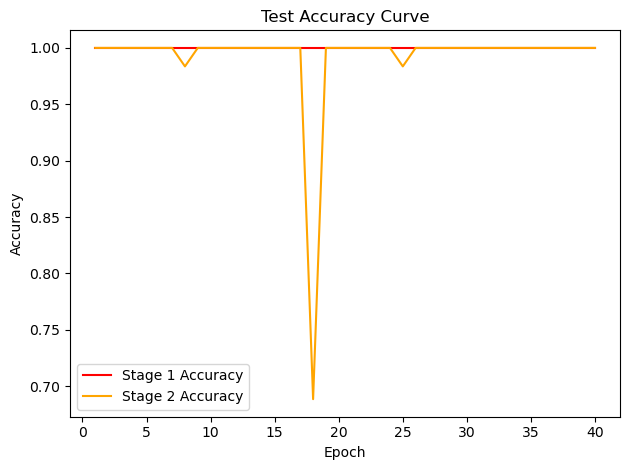

In [74]:
# Accuracy plots

plt.plot(epochs, accuracies_stage1, label='Stage 1 Accuracy', color='red')
plt.plot(epochs, accuracies_stage2, label='Stage 2 Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Curve")
plt.legend()


plt.tight_layout()
plt.show()